In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from statsmodels.distributions.empirical_distribution import ECDF
import statistics
import seaborn as sns
import math
from tqdm import tqdm
import scipy

%matplotlib inline

In [2]:
sample_xlsx = pd.read_excel('Борисова Ксения.xlsx')
sample_xlsx.head()

,Unnamed: 0,Выборка
0,0,-0.168077
1,1,1.273907
2,2,4.157059
3,3,6.078875
4,4,2.606514


In [3]:
sample = np.array(sample_xlsx['Выборка'])
sample.shape

(1000000,)

Дана выборка из 1000000 элементов. Визуализируем ее

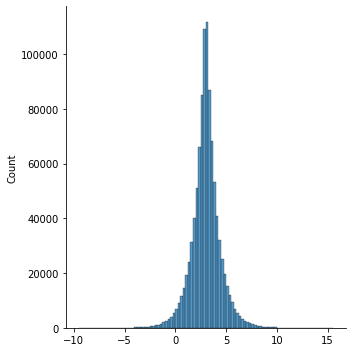

In [4]:
sns.displot(sample, bins=100)

# Задание 1

Видно, что выборка симметрична. Проверим ее распределение на совпадение с нормальным, Коши и Лапласом

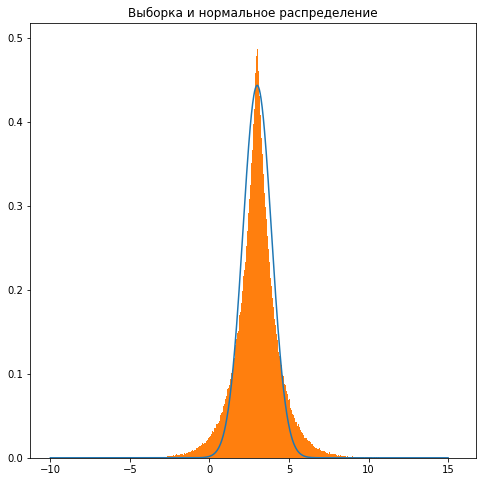

In [5]:
x = np.linspace(-10,15,1000)
norm_rv = sts.norm(3, 0.9)
norm_pdf = norm_rv.pdf(x)

plt.figure(figsize=(8, 8))
plt.plot(x, norm_pdf)
plt.hist(sample, bins = 1000, density = True)
plt.title('Выборка и нормальное распределение')
plt.show()

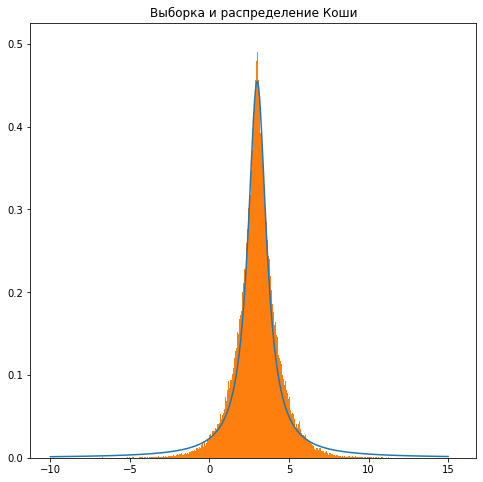

In [6]:
cauchy_rv = sts.cauchy(3, 0.7)
cauchy_pdf = cauchy_rv.pdf(x)

plt.figure(figsize=(8, 8))
plt.plot(x, cauchy_pdf)
plt.hist(sample, bins = 5000, density = True)
plt.title('Выборка и распределение Коши')
plt.show()

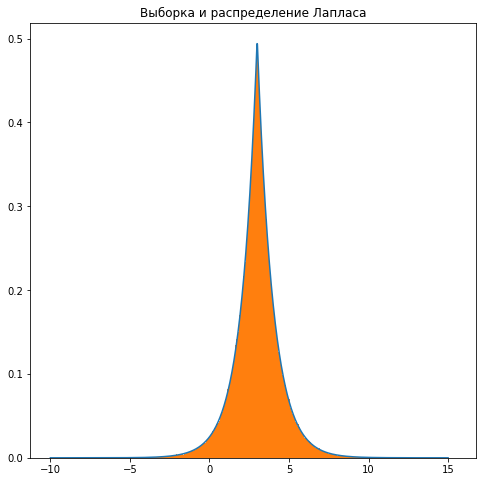

In [7]:
laplace_rv = sts.laplace(loc=3, scale=1)
laplace_pdf = laplace_rv.pdf(x)

plt.figure(figsize=(8, 8))
plt.plot(x, laplace_pdf)
plt.hist(sample, bins = 1000, density = True)
plt.title('Выборка и распределение Лапласа')
plt.show()

Ясно, что это выборка Лапласа с параметром масштаба 1 и параметром сдвига 3. Посмотрим на функции распределения

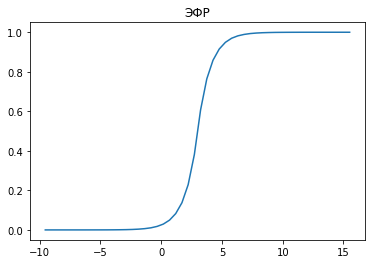

In [8]:
ecdf = ECDF(sample)
x = np.linspace(min(sample), max(sample))
edf = ecdf(x)
plt.title('ЭФР')
plt.plot(x, edf)

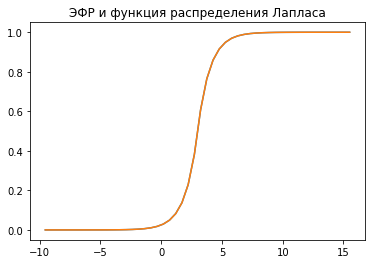

In [9]:
laplace_cdf = [laplace_rv.cdf(i) for i in x]
plt.plot(x, edf)
plt.title('ЭФР и функция распределения Лапласа')
plt.plot(x, laplace_cdf)

# Задание 2

Оценку метода моментов для $ \alpha $ (scale) и $ \beta $ (loc) получим из значений дисперсии и матожидания для распределения Лапласа:

$ EX = \beta $

$ DX = \frac{2}{\alpha^2} $

In [10]:
n = len(sample)

E1 = np.sum(sample)/n
E2 = np.sum(np.square(sample))/n
D = E2 - E1**2
moment_scale = math.sqrt(2/D)
moment_loc = E1
print(r"OMМ для loc:", moment_loc, "OMМ для scale:", moment_scale)

OMМ для loc: 3.0003813401404 OMМ для scale: 0.9995826565480579


Оценки максимального правдоподобия найдем с помощью функции sts.laplace.fit

In [11]:
fit_loc, fit_scale = sts.laplace.fit(sample)
print("OMП для loc:", fit_loc, "OMП для scale:", fit_scale)

OMП для loc: 2.99953255 OMП для scale: 1.0006467189302


# Задание 3

Проверим ОММ на состоятельность: будем считать оценки для выборок разного размера. Видно, что с какого-то момента оценки находятся достаточно близко к искомым значениям

In [12]:
moment_loc_array = []
moment_scale_array = []

for i in tqdm(range(100, n, 10000)):
    little_sample = sample[:i]
    E1 = np.sum(little_sample)/i
    E2 = np.sum(np.square(little_sample))/i
    D = E2 - E1**2
    moment_scale_i = math.sqrt(2/D)
    moment_loc_i = E1
    moment_scale_array.append(moment_scale_i)
    moment_loc_array.append(moment_loc_i)

100%|██████████| 100/100 [00:00<00:00, 816.68it/s]


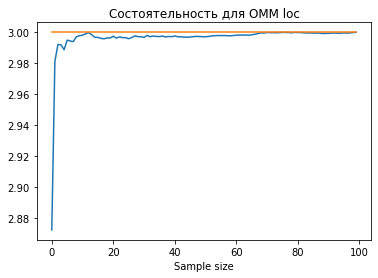

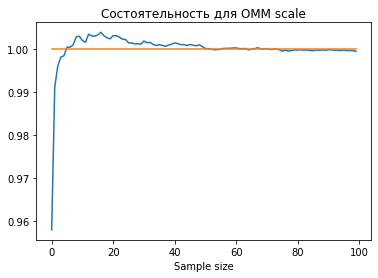

In [13]:
x = np.arange(len(moment_loc_array))
plt.plot(x, moment_loc_array)
plt.plot(x, [3 for _ in x])
plt.xlabel('Sample size')
plt.title('Состоятельность для ОММ loc')
plt.show()

x = np.arange(len(moment_scale_array))
plt.plot(x, moment_scale_array)
plt.plot(x, [1 for _ in x])
plt.xlabel('Sample size')
plt.title('Состоятельность для ОММ scale')
plt.show()

Теперь проверим ОМП:

In [14]:
fit_loc_array = []
fit_scale_array = []

for i in tqdm(range(100, n, 10000)):
    little_sample = sample[:i]
    fit_loc_i, fit_scale_i = sts.laplace.fit(little_sample)
    fit_loc_array.append(fit_loc_i)
    fit_scale_array.append(fit_scale_i)

100%|██████████| 100/100 [00:00<00:00, 117.81it/s]


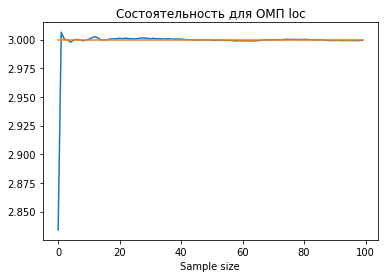

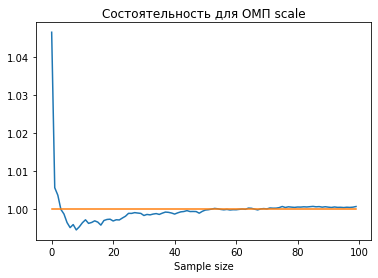

In [15]:
x = np.arange(len(fit_loc_array))
plt.plot(x, fit_loc_array)
plt.plot(x, [3 for _ in x])
plt.xlabel('Sample size')
plt.title('Состоятельность для ОМП loc')
plt.show()

x = np.arange(len(fit_scale_array))
plt.plot(x, fit_scale_array)
plt.plot(x, [1 for _ in x])
plt.xlabel('Sample size')
plt.title('Состоятельность для ОМП scale')
plt.show()

Теперь посмотрим на асимптотическую нормальность. Возьмем много выборок фиксированного размера и посмотрим на оценки параметров для них. Потом нарисуем гистограмму и попробуем "подогнать" под какое-нибудь нормальное распределение

In [16]:
asimpt_norm_m_loc = []
asimpt_norm_m_scale = []

for i in tqdm(range(100000)):
    little_sample = np.random.choice(sample, size = 10000)
    E1 = np.sum(little_sample)/10000
    E2 = np.sum(np.square(little_sample))/10000
    D = E2 - E1**2
    moment_scale_i = math.sqrt(2/D)
    moment_loc_i = E1
    asimpt_norm_m_loc.append(math.sqrt(10000)*(moment_loc_i - 3))
    asimpt_norm_m_scale.append(math.sqrt(10000)*(moment_scale_i - 1))

100%|██████████| 100000/100000 [00:24<00:00, 4109.11it/s]


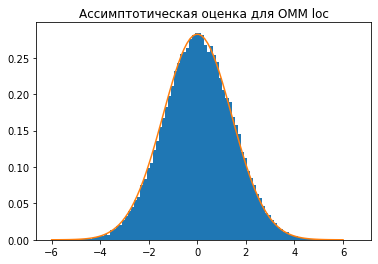

Примерный коэффициент АНО для ОМM(loc): 1.9929243848924443


In [17]:
plt.hist(asimpt_norm_m_loc, bins=100, density=True)
x = np.linspace(-6, 6, 100)
scale = statistics.variance(asimpt_norm_m_loc)
plt.plot(x, sts.norm.pdf(x, scale = math.sqrt(scale)))
plt.title('Ассимптотическая оценка для ОММ loc')
plt.show()
print('Примерный коэффициент АНО для ОМM(loc):', scale)

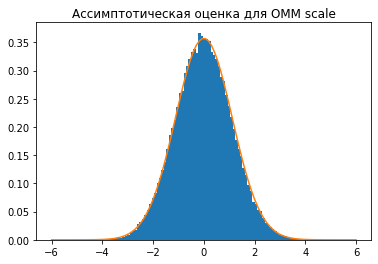

Примерный коэффициент АНО для ОМM(scale): 1.2472021150749508


In [18]:
plt.hist(asimpt_norm_m_scale, bins=100, density=True)
x = np.linspace(-6, 6, 100)
scale = statistics.variance(asimpt_norm_m_scale)
plt.plot(x, sts.norm.pdf(x, scale = math.sqrt(scale)))
plt.title('Ассимптотическая оценка для ОММ scale')
plt.show()
print('Примерный коэффициент АНО для ОМM(scale):', scale)

In [19]:
asimpt_norm_fit_loc = []
asimpt_norm_fit_scale = []

for i in tqdm(range(100000)):
    little_sample = np.random.choice(sample, size = 10000)
    fit_loc_i, fit_scale_i = sts.laplace.fit(little_sample)
    asimpt_norm_fit_loc.append(math.sqrt(10000)*(fit_loc_i - 3))
    asimpt_norm_fit_scale.append(math.sqrt(10000)*(fit_scale_i - 1))

100%|██████████| 100000/100000 [00:46<00:00, 2160.24it/s]


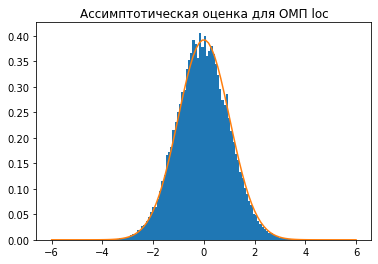

Примерный коэффициент АНО для ОМП(loc): 1.0353814959495717


In [20]:
plt.hist(asimpt_norm_fit_loc, bins=100, density=True)
x = np.linspace(-6, 6, 100)
scale = statistics.variance(asimpt_norm_fit_loc)
plt.plot(x, sts.norm.pdf(x, scale = math.sqrt(scale)))
plt.title('Ассимптотическая оценка для ОМП loc')
plt.show()
print('Примерный коэффициент АНО для ОМП(loc):', scale)

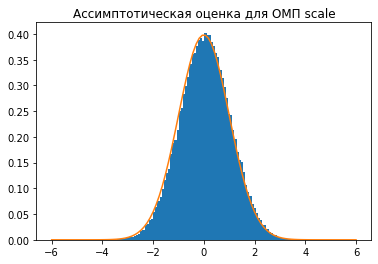

Примерный коэффициент АНО для ОМП(scale): 1.0038144068871302


In [21]:
plt.hist(asimpt_norm_fit_scale, bins=100, density=True)
x = np.linspace(-6, 6, 100)
scale = statistics.variance(asimpt_norm_fit_scale)
plt.plot(x, sts.norm.pdf(x, scale = math.sqrt(scale)))
plt.title('Ассимптотическая оценка для ОМП scale')
plt.show()
print('Примерный коэффициент АНО для ОМП(scale):', scale)

# Задание 4

Построим доверительные интервалы уровней доверия 0.95 и 0.99

In [22]:
def mean_confidence_interval(data, confidence):
    n = len(data)
    m, se = np.mean(data), sts.sem(data)
    h = se * sts.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

In [23]:
print("Доверительный интервал уровня 0.95:", mean_confidence_interval(sample, 0.95))
print("Доверительный интервал уровня 0.99:", mean_confidence_interval(sample, 0.99))

Доверительный интервал уровня 0.95: (2.997608370470154, 3.0031543098106455)
Доверительный интервал уровня 0.99: (2.9967370377047455, 3.004025642576054)


# Задание 5

Посмотрим на значение теста Колмогорова для нашей выборки

In [24]:
sts.kstest(sample, 'laplace', (3, 1))

KstestResult(statistic=0.0007250239705072214, pvalue=0.6689940497599782)

# Задание 6

Я взяла экпоненциальное распределение и попробовала построить результаты теста Колмогорова для выборок разного размера. Сначала я взяла истинные параметры, а потом оцененные ОМП. С ОМП получилась крайне странная функция (возможно, ошибка в программе)

100%|██████████| 98/98 [00:17<00:00,  5.53it/s]


Text(0, 0.5, '$\\sup |F*_n(t)-F(t)|$')

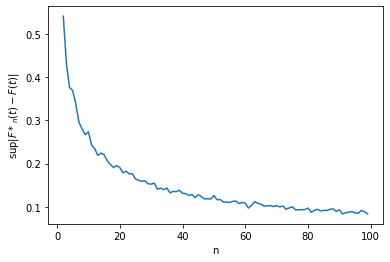

In [25]:
y = []
mean = 1
dispersion = 1
exp_rv = sts.expon(scale=1)
for n in tqdm(range(2, 100)):
    ktest = []
    for _ in range(100):
        sample1 = exp_rv.rvs(n)
        ktest.append(scipy.stats.kstest(sample1, 'expon')[0])
    y.append(sum(ktest)/100)

x = np.arange(2, 100)
plt.plot(x, y)
plt.xlabel('n')
plt.ylabel(r'$\sup |F*_n(t)-F(t)|$')

In [26]:
y = []
for n in tqdm(range(2, 100)):
    samples = []
    ktest = []
    for _ in range(100):
        for _ in range(100):
            sample1 = exp_rv.rvs(n)
            beta, alpha = sts.expon.fit(sample1)
            mean=beta
            dispertion = 2/alpha**2
            samples.append((sum(sample1) - n*mean)/math.sqrt(n*dispersion))
        ktest.append(scipy.stats.kstest(samples, 'norm')[0])
    y.append(sum(ktest)/100)


100%|██████████| 98/98 [01:46<00:00,  1.08s/it]


Text(0, 0.5, '$\\sup |F*_n(t)-F(t)|$')

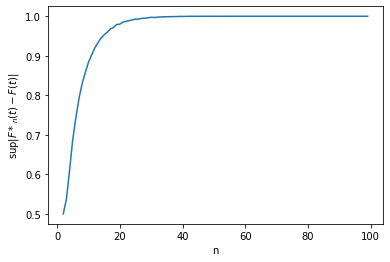

In [27]:
x = np.arange(2, 100)
plt.plot(x, y)
plt.xlabel('n')
plt.ylabel(r'$\sup |F*_n(t)-F(t)|$')

# Задание 7

Теперь посмотрим на выборку с шумом

In [28]:
noise = pd.read_excel('Борисова Ксения.xlsx', 'Sheet2', engine='openpyxl')

In [29]:
noise.head()

,Unnamed: 0,Шум
0,0,3.749254
1,1,2.029068
2,2,0.593184
3,3,20.092125
4,4,5.184715


In [30]:
noise = np.array(noise['Шум'])
noise.shape

(6000,)

In [31]:
sample = np.concatenate([noise, sample])

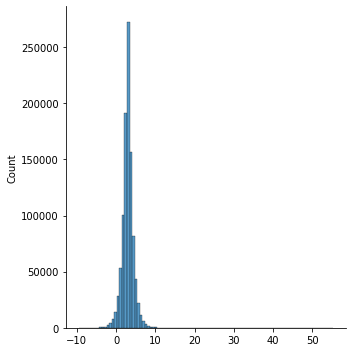

In [32]:
sns.displot(sample, bins=100)

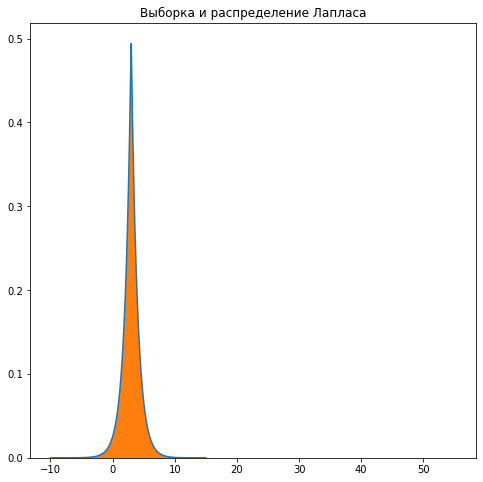

In [33]:
laplace_rv = sts.laplace(loc=3, scale=1)
x = np.linspace(-10,15,1000)
laplace_pdf = laplace_rv.pdf(x)
plt.figure(figsize=(8, 8))
plt.plot(x, laplace_pdf)
plt.hist(sample, bins = 1000, density = True)
plt.title('Выборка и распределение Лапласа')
plt.show()

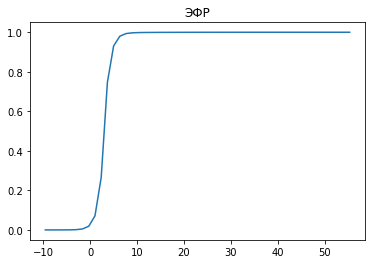

In [34]:
ecdf = ECDF(sample)
x = np.linspace(min(sample), max(sample))
edf = ecdf(x)
plt.title('ЭФР')
plt.plot(x, edf)

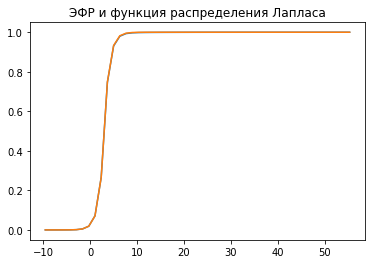

In [35]:
laplace_cdf = [laplace_rv.cdf(i) for i in x]
plt.plot(x, edf)
plt.title('ЭФР и функция распределения Лапласа')
plt.plot(x, laplace_cdf)

In [36]:
n = len(sample)

E1 = np.sum(sample)/n
E2 = np.sum(np.square(sample))/n
D = E2 - E1**2
moment_scale = math.sqrt(2/D)
moment_loc = E1
print(r"OMМ для loc:", moment_loc, "OMМ для scale:", moment_scale)

OMМ для loc: 3.0239056016752506 OMМ для scale: 0.9188257682299295


In [37]:
fit_loc, fit_scale = sts.laplace.fit(sample)
print("OMП для loc:", fit_loc, "OMП для scale:", fit_scale)

OMП для loc: 3.00135505 OMП для scale: 1.0250499670470177


In [38]:
moment_loc_array = []
moment_scale_array = []

for i in tqdm(range(100, n, 10000)):
    little_sample = sample[:i]
    E1 = np.sum(little_sample)/i
    E2 = np.sum(np.square(little_sample))/i
    D = E2 - E1**2
    moment_scale_i = math.sqrt(2/D)
    moment_loc_i = E1
    moment_scale_array.append(moment_scale_i)
    moment_loc_array.append(moment_loc_i)

100%|██████████| 101/101 [00:00<00:00, 580.90it/s]


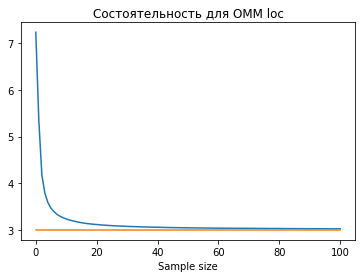

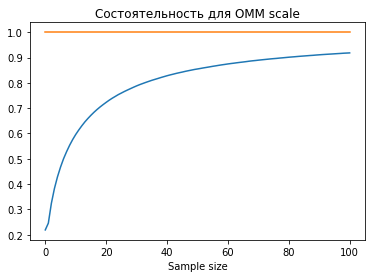

In [39]:
x = np.arange(len(moment_loc_array))
plt.plot(x, moment_loc_array)
plt.plot(x, [3 for _ in x])
plt.xlabel('Sample size')
plt.title('Состоятельность для ОММ loc')
plt.show()

x = np.arange(len(moment_scale_array))
plt.plot(x, moment_scale_array)
plt.plot(x, [1 for _ in x])
plt.xlabel('Sample size')
plt.title('Состоятельность для ОММ scale')
plt.show()

In [40]:
fit_loc_array = []
fit_scale_array = []

for i in tqdm(range(100, n, 10000)):
    little_sample = sample[:i]
    fit_loc_i, fit_scale_i = sts.laplace.fit(little_sample)
    fit_loc_array.append(fit_loc_i)
    fit_scale_array.append(fit_scale_i)

100%|██████████| 101/101 [00:00<00:00, 121.85it/s]


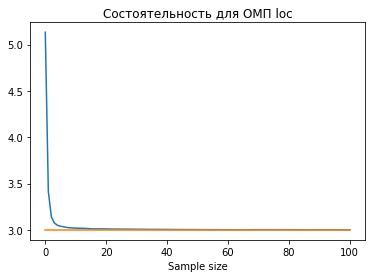

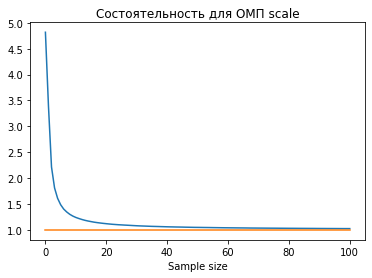

In [41]:
x = np.arange(len(fit_loc_array))
plt.plot(x, fit_loc_array)
plt.plot(x, [3 for _ in x])
plt.xlabel('Sample size')
plt.title('Состоятельность для ОМП loc')
plt.show()

x = np.arange(len(fit_scale_array))
plt.plot(x, fit_scale_array)
plt.plot(x, [1 for _ in x])
plt.xlabel('Sample size')
plt.title('Состоятельность для ОМП scale')
plt.show()

In [42]:
asimpt_norm_m_loc = []
asimpt_norm_m_scale = []

for i in tqdm(range(100000)):
    little_sample = np.random.choice(sample, size = 10000)
    E1 = np.sum(little_sample)/10000
    E2 = np.sum(np.square(little_sample))/10000
    D = E2 - E1**2
    moment_scale_i = math.sqrt(2/D)
    moment_loc_i = E1
    asimpt_norm_m_loc.append(math.sqrt(10000)*(moment_loc_i - 3))
    asimpt_norm_m_scale.append(math.sqrt(10000)*(moment_scale_i - 1))

100%|██████████| 100000/100000 [00:21<00:00, 4736.62it/s]


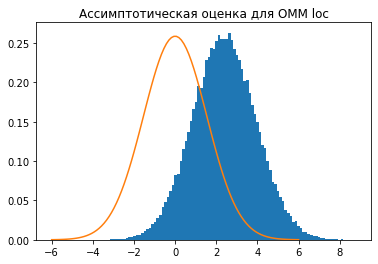

Примерный коэффициент АНО для ОМM(loc): 2.3763472156754735


In [43]:
plt.hist(asimpt_norm_m_loc, bins=100, density=True)
x = np.linspace(-6, 6, 100)
scale = statistics.variance(asimpt_norm_m_loc)
plt.plot(x, sts.norm.pdf(x, scale = math.sqrt(scale)))
plt.title('Ассимптотическая оценка для ОММ loc')
plt.show()
print('Примерный коэффициент АНО для ОМM(loc):', scale)

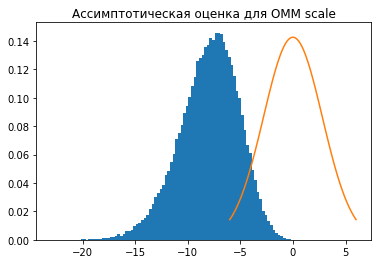

Примерный коэффициент АНО для ОМM(scale): 7.8106444579553


In [44]:
plt.hist(asimpt_norm_m_scale, bins=100, density=True)
x = np.linspace(-6, 6, 100)
scale = statistics.variance(asimpt_norm_m_scale)
plt.plot(x, sts.norm.pdf(x, scale = math.sqrt(scale)))
plt.title('Ассимптотическая оценка для ОММ scale')
plt.show()
print('Примерный коэффициент АНО для ОМM(scale):', scale)

In [45]:
asimpt_norm_fit_loc = []
asimpt_norm_fit_scale = []

for i in tqdm(range(100000)):
    little_sample = np.random.choice(sample, size = 10000)
    fit_loc_i, fit_scale_i = sts.laplace.fit(little_sample)
    asimpt_norm_fit_loc.append(math.sqrt(10000)*(fit_loc_i - 3))
    asimpt_norm_fit_scale.append(math.sqrt(10000)*(fit_scale_i - 1))

100%|██████████| 100000/100000 [00:37<00:00, 2637.95it/s]


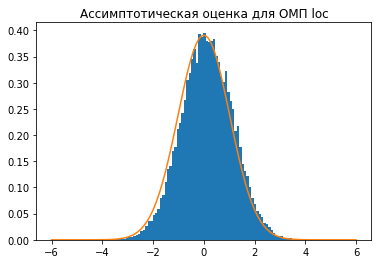

Примерный коэффициент АНО для ОМП(loc): 1.0417657170618617


In [46]:
plt.hist(asimpt_norm_fit_loc, bins=100, density=True)
x = np.linspace(-6, 6, 100)
scale = statistics.variance(asimpt_norm_fit_loc)
plt.plot(x, sts.norm.pdf(x, scale = math.sqrt(scale)))
plt.title('Ассимптотическая оценка для ОМП loc')
plt.show()
print('Примерный коэффициент АНО для ОМП(loc):', scale)

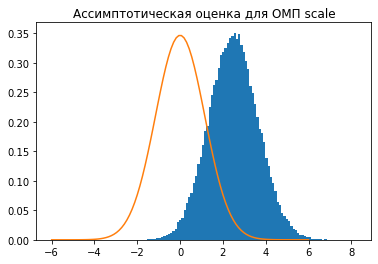

Примерный коэффициент АНО для ОМП(scale): 1.3229598335212882


In [47]:
plt.hist(asimpt_norm_fit_scale, bins=100, density=True)
x = np.linspace(-6, 6, 100)
scale = statistics.variance(asimpt_norm_fit_scale)
plt.plot(x, sts.norm.pdf(x, scale = math.sqrt(scale)))
plt.title('Ассимптотическая оценка для ОМП scale')
plt.show()
print('Примерный коэффициент АНО для ОМП(scale):', scale)

In [48]:
def mean_confidence_interval(data, confidence):
    n = len(data)
    m, se = np.mean(data), sts.sem(data)
    h = se * sts.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

In [49]:
print("Доверительный интервал уровня 0.95:", mean_confidence_interval(sample, 0.95))
print("Доверительный интервал уровня 0.99:", mean_confidence_interval(sample, 0.99))

Доверительный интервал уровня 0.95: (3.0208979213804077, 3.0269132819700935)
Доверительный интервал уровня 0.99: (3.019952836992635, 3.027858366357866)


In [50]:
sts.kstest(sample, 'laplace', (3, 1))

KstestResult(statistic=0.0028669720197516124, pvalue=1.312114548203202e-07)

С добавлением шума ассимптотическая нормальность ОММ и ОМП ломается, но состоятельность похоже все равно остается